loss 0.003, train acc 0.999, test acc 0.990
21182.8 examples/sec on cuda:0


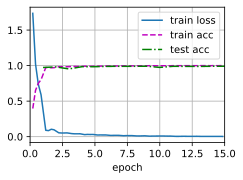

In [34]:
!pip install d2l==0.14.4 # Run if d2l is not already installed

import numpy as np
import matplotlib.pyplot as plt
from d2l import torch as d2l
import torch
from torch import nn
from torchvision import transforms
import torchvision

def imshow(img):
    img = img     # unnormalize
    npimg = img.detach().numpy()
    tpimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(tpimg)
    plt.show()
    
def VisualizeImageGrayscale(image_3d):
  r"""Returns a 3D tensor as a grayscale normalized between 0 and 1 2D tensor.
  """
  vmin = torch.min(image_3d)
  image_2d = image_3d - vmin
  vmax = torch.max(image_2d)
  return (image_2d / vmax)

def get_dataloader_workers():  #@save
    """Use 4 processes to read the data."""
    return 4

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1,1,28,28)

net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=5), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

X = torch.randn(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

batch_size = 256
trans = [transforms.ToTensor()]
trans = transforms.Compose(trans)
mnist_train = torchvision.datasets.MNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.MNIST(
    root="../data", train=False, transform=trans, download=True)
train_iter, test_iter = (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                        num_workers=get_dataloader_workers()),
                        torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                                        num_workers=get_dataloader_workers()))

def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss = metric[0]/metric[2]
            train_acc = metric[1]/metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

"""Now let us train and evaluate the LeNet-5 model."""

lr, num_epochs = 0.8, 15
train_ch6(net, train_iter, test_iter, num_epochs, lr)

#net[1].weight
#imshow(torchvision.utils.make_grid(VisualizeImageGrayscale(net[1].weight)))

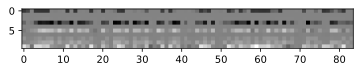

Activations for Layer1


In [40]:
imshow(torchvision.utils.make_grid(VisualizeImageGrayscale((net[-1].weight.grad).clone().detach().cpu())))
print('Activations for Layer1')

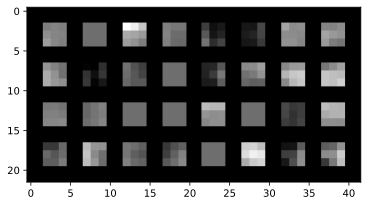

Activations for Layer2


In [39]:
imshow(torchvision.utils.make_grid(VisualizeImageGrayscale((net[1].weight.grad).clone().detach().cpu())))
print('Activations for Layer2')